建立对数几率回归模型：

In [2]:
import sys
import numpy as np
from scipy.special import expit

class LogisticModel(object):
    def __init__(self,X,y,epoch_times=1000,visible=False,alpha=0.001):
        '''args:
            X(m*n):np数组的样本集,包含m个样本,每个样本包含n个属性
            y:标签集
            m/n:样本数/属性数
            w:权重向量
            X_new:扩展后的样本集
            epoch_times:梯度下降法中的迭代次数
            visible:训练过程是否可视化
            alpha:梯度下降法中的学习率
        '''
        self.X=X
        self.y=y
        self.m=self.X.shape[0]
        self.n=self.X.shape[1]
        self.w=self.Init_wgt()
        self.X_new=self.Add_bias()
        self.visible=visible
        self.alpha=alpha
        self.epoch_times=epoch_times

    def Add_bias(self):             #为样本集X增加一列并返回新数组(m*(n+1))
        X_new=np.ones((self.m,self.n+1))
        X_new[:,1:]=self.X          #x=(1,x)
        return X_new
    def Init_wgt(self):             #初始化w(n+1,1):-1~1上均匀分布的随机数
        w=np.random.uniform(-1.0,1.0,size=self.n+1)
        w.reshape(self.n+1,1)       #一定要合并大小
        return w

    def Sigmoid(self,z):            #激活函数
        return expit(z)             #expit(z)=1/(1+np.exp(-z))
    def Sigmoid_gradient(self,z):   #激活函数的梯度
        sg=self.Sigmoid(z)
        return sg*(1-sg)            #对应位置相乘即可

    def Cost(self,w,x):             #损失函数J(w),实数值
        cst=0.0
        z=np.matmul(x,w)
        for i in range(self.m):
            hw=self.Sigmoid(z[i])
            cst+=self.y[i]*np.log(hw)+(1-self.y[i])*np.log(1-hw)
        cst/=(-self.m)
        return cst
    def Gradient(self,w,x):         #J(w)对w的导数,与w同维的向量
        cnt=[0]*(self.n+1)
        z=np.matmul(x,w)
        for i in range(self.m):
            hw=self.Sigmoid(z[i])
            cnt+=(hw-self.y[i])*x[i]
        cnt/=self.m
        cnt=np.array(cnt)
        cnt.reshape(self.n+1,1)
        return cnt

    def GD(self):                   #梯度下降求解w,并记录损失函数的下降过程
        cst=[self.Cost(self.w,self.X_new)]
        for i in range(self.epoch_times):
            if self.visible:        #训练过程可视化
                sys.stderr.write("\rEpoch times: %d/%d "%(i+1,self.epoch_times)+\
                    "▋"*(i//(self.epoch_times//20)))
                sys.stderr.flush()

            delta=self.Gradient(self.w,self.X_new)
            self.w-=self.alpha*delta
            cst.append(self.Cost(self.w,self.X_new))
        if self.visible:
            sys.stderr.flush()
        return cst

对西瓜数据集3.0里的"密度"和"含糖率"属性进行分类：

Epoch times: 10000/10000 ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋


Accuracy of classification: 52.94%


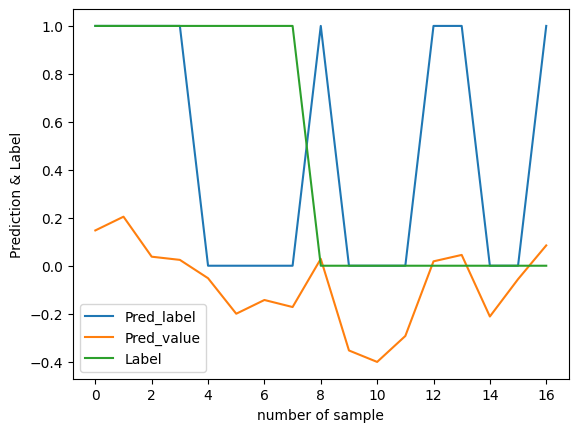

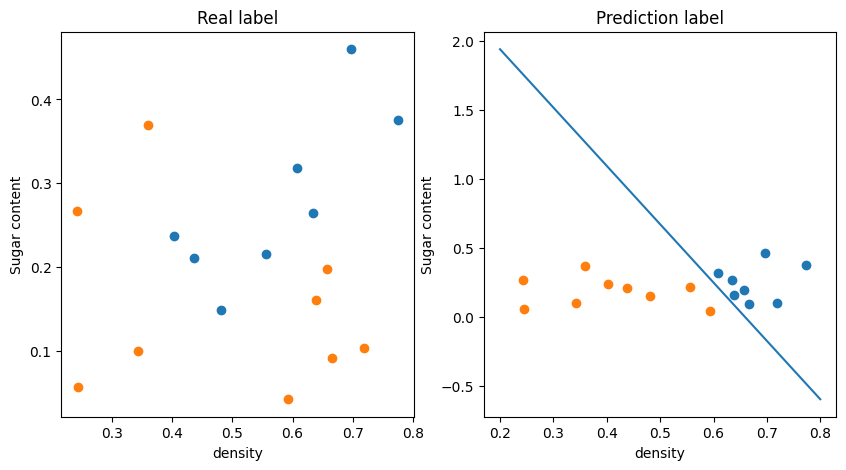

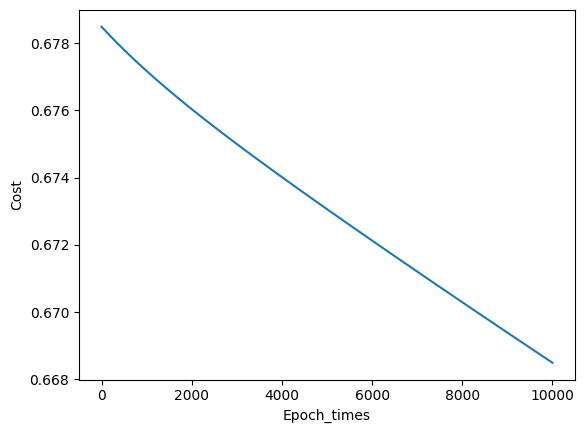

In [18]:
import csv
import numpy as np
import matplotlib.pyplot as plt

#读取西瓜数据集
f=open(r'data/watermelon_3a.csv',encoding='GB2312')
reader=csv.reader(f)
rows=[row for row in reader]        #rows[i]=[编号,密度,含糖率,好瓜]
X=[]                                #样本集
y=[]                                #标签值
for i in range(1,len(rows)):
    X.append([float(rows[i][1]),float(rows[i][2])])
    y.append(int(rows[i][4]))
X=np.array(X)                       #将list转变成numpy数组
y=np.array(y)
# print(X,y)
#实例化LogisticModel对象并进行训练
ep=10000                         #训练次数,可更改
lm=LogisticModel(X,y,ep,True)
cst=lm.GD()
w=lm.w

#计算准确率
pred_z=[]
pred_l=[]
acc=0
for x in lm.X_new:
    z=np.matmul(x,w)
    pred_z.append(z)
    if z>=0:
        pred_l.append(1)
    else:
        pred_l.append(0)
    if(pred_l[len(pred_l)-1]==y[len(pred_l)-1]):
        acc+=1
acc/=len(pred_l)
print('\nAccuracy of classification: %.2f%%'%(acc*100))

pred1=[]                            #预测正类的样本点集合
pred0=[]                            #预测负类的样本点集合
for i in range(len(pred_l)):
    if(pred_l[i]==1):
        pred1.append([X[i][0],X[i][1]])
    else:
        pred0.append([X[i][0],X[i][1]])
pred1=np.array(pred1)
pred0=np.array(pred0)

#绘制分类结果1(预测值+预测标签+真实标签)
plt.plot(range(len(pred_l)),pred_l,pred_z)
plt.plot(range(len(pred_l)),y)
plt.ylabel('Prediction & Label')
plt.xlabel('number of sample')
plt.legend(['Pred_label','Pred_value','Label'])
plt.show()

#绘制分类结果2(真实分类&预测分类)
fig0=plt.figure(figsize=(10,5))
ax=plt.subplot(121)                 #真实分类
ax.scatter(X[:8,0],X[:8,1])         #正类
ax.scatter(X[8:,0],X[8:,1])         #负类
ax.set_xlabel('density')
ax.set_ylabel('Sugar content')
ax.set_title("Real label")
ax=plt.subplot(122)                 #预测分类
ax.scatter(pred1[:,0],pred1[:,1])
ax.scatter(pred0[:,0],pred0[:,1])
ax.set_xlabel('density')
ax.set_ylabel('Sugar content')
ax.set_title("Prediction label")
a=np.linspace(0.2,0.8,1000)
b=-(w[1]*a+w[0])/w[2]
ax.plot(a,b)
plt.show()

#绘制损失函数
plt.plot(range(len(cst)),cst)
plt.ylabel('Cost')
plt.xlabel('Epoch_times')
plt.show()

西瓜数据集训练结果：迭代10000次的准确率为70.59%。
预测值、预测标签与真实标签折线图如下：

<img src="https://img-blog.csdnimg.cn/5bc42c7c58124c7696976f3ca310c767.png" width="40%" alt="" />

预测结果散点图：

<img src="https://img-blog.csdnimg.cn/2e885160c3174552ae472dbbf8dcbcf7.png" width="40%" alt="" />


训练过程损失函数如下：

<img src="https://img-blog.csdnimg.cn/10ef059ebfdf42af9cdf603d94e9c1d2.png" width="40%" alt="" />


对鸢尾花数据集进行多分类：

In [ ]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

def Cal(X,w,c1,c0):                 #计算X*w,预测X_new对应分类
    '''args:
        X:测试集
        w:参数
        c1:正类标签
        c0:负类标签
    '''
    pred=[]
    for x in X:
        x_new=list(x.copy())
        x_new.insert(0,1)
        z=np.matmul(x_new,w)
        if z>=0:
            pred.append(c1)
        else:
            pred.append(c0)
    return pred

#读取鸢尾花数据集
iris = datasets.load_iris()         #sklearn中自带的鸢尾花数据集的字典,包含了许多信息
data=iris['data']                   #数据集属性值的np数组
label=iris['target']                #数据集标签值的np数组
feature=iris['feature_names']       #数据集属性名列表
target=iris['target_names']
target=list(target)                 #标签名列表

#将数据集按7:3分割成训练集和测试集
data_train=[]                       #训练集属性
data_test=[]                        #训练集标签
label_train=[]                      #测试集属性
label_test=[]                       #测试集标签
for i in range(len(data)):
    if(i%10<7):
        data_train.append(data[i])
        label_train.append(label[i])
    else:
        data_test.append(data[i])
        label_test.append(label[i])

#从训练集中划分不同类别的样本
k=len(target)                       #类别数
data_train_target=[[] for i in range(k)]    #按类别划分的训练样本属性
for i in range(len(data_train)):
    data_train_target[label_train[i]].append(data_train[i])

#采用OvO拆分策略推广对数几率回归模型
Pred_l=[]                           #存放k(k-1)/2个模型对测试集的预测结果
ep=10000
for i in range(k):
    for j in range(k):
        if(i==j):
            continue
        #将i作为正类,j作为负类
        Xtmp=data_train_target[i].copy()
        Xtmp.extend(data_train_target[j])
        ytmp=[1]*len(data_train_target[i])
        ytmp2=[0]*len(data_train_target[j])
        ytmp.extend(ytmp2)
        Xtmp=np.array(Xtmp)
        ytmp=np.array(ytmp)
        lm=LogisticModel(Xtmp,ytmp,ep)
        cst=lm.GD()
        w=lm.w
        Pred_l.append(Cal(data_test,w,i,j))
        print("Finished training on the basis of Trainset %d and %d."%(i,j))
pred_l=[]                           #存放测试集的最终预测结果
for i in range(len(Pred_l[0])):     #遍历列
    l_lst={}                        #暂时存放一列中不同标签的出现次数
    for j in range(len(Pred_l)):    #遍历一列中的每个元素
        l_lst[Pred_l[j][i]]=l_lst.get(Pred_l[j][i],0)+1
    k,v=max(l_lst.items(),key=lambda x:x[1])
    pred_l.append(k)
# print(pred_l)

#计算准确率
acc=0
for i in range(len(pred_l)):
    if(pred_l[i]==label_test[i]):
        acc+=1
acc/=len(label_test)
print('Accuracy of classification: %.2f%%'%(acc*100))

鸢尾花数据集训练结果：

迭代10000次的准确率为95.56%；

迭代100000次的准确率为100.00%；
